Task 1
If you were asked to build a model for predicting arousal and valence, using the provided audio
features as explanatory variables:

1. Which performance metrics would you use to evaluate your model’s predictions?

To evaluate our model’s performance, we would use the following metrics. Mean Squared Error and Root Mean Squared Error as they're fairly common metric for measuring the differences between the predicted and the actual values, the root of MSE expresses this error in the same units as the target variable, allowing for more intuitive interpretation. We would also make use of Median Absolute Error, which is similar to MSEand focuses on the median of the absolute errors, we included it as it aligns well with our goal of predicting the medians. Lastly we chose the R² score, as it tells us the proportion of variance in the predicted values explained by the model, indicating how well the model captures underlying patterns in the data.

2. Does the selection of the performance metric depend on the type of the response
variables? Explain your reasoning.

Yes, naturally different performance metrics are more accustomed to different responses, given if our response varaible is regressive or catergorical would result in different performance metrics being used. For example we particularly chose Median Absolute Error when considering the response variable as it conceptually aligns with our predicted target.

3. Which validation protocol (e.g., holdout set, k-fold cross-validation, etc.) would you
use given that the objective is to build a predictive model able to generalise across
participants (i.e., make accurate predictions for unseen participants)? Justify your
choice.

We would make use of Leave-One-Group-Out a cross-validation technique that aligns with our dataset. In LOGO we keep the data of the participants data used for training and testing seperate, this ensures that during the test set it mirrors a real-world scenario where the model where we would be expected to predict arousal and valence levels for entirely new unseen participant. This approach would give us a strict separation between training and testing data at the participant level, preventing data leakage and overfitting that could occur if information from the same individual appeared in both sets.

Task 2 Using the provided audio features, build predictive models for arousal and valence:

1. Develop a predictive model for each response variable (arousal and valence) using
some or all of the provided audio features as explanatory variables

First we preprocessed the dataset using feature selection; separating the target variables, median_arousal and median_valence, from the feature set. These will serve as the outputs our models aim to predict and therefore they should not be included in the training dataset. We also excluded the Participant ID as this is a categorical identifier unique to each individual, including this as a feature would make sense for a regreseeive model.

We implemented random participant holdout as a validation technique, by randomly setting aside a subset of participants during model training. The Participant ID played a crucial role for implementing this as we could set aside participants in their entirity. With this method we could be sure that no data leakage could occur during training, if we simply split a participants recordings into a training and test sets the model may easily perform unrealisitically well (given it already has training knowledge regarding them), rather than a real life scenario where an unseen participant would need to be identified.

We then used the standard scaler to scale the data, naturally we didnt need to use Label Encoding or One-Hot Encoding as there are no catergorical values in the resulting dataset.

In [37]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
import random

df = pd.read_csv("project_data.csv")
scaler = StandardScaler()

y_arousal = pd.concat([df['Participant'], df['median_arousal']], axis=1)
y_valence = pd.concat([df['Participant'], df['median_valence']], axis=1)
df = df.drop(columns=['median_arousal', 'median_valence'])

# Get participant list
last_participant = df.iloc[[-1]]
participant_list = list(range(1, int(last_participant['Participant']) + 1))

# 80/20 test-train split
test_participants_index = random.sample(participant_list, 2)
train_participants_index = [item for item in participant_list if item not in test_participants_index]

x_test = pd.concat([df[df['Participant'] == index] for index in test_participants_index])
x_train = pd.concat([df[df['Participant'] == index] for index in train_participants_index])
y_test_arousal = pd.concat([y_arousal[y_arousal['Participant'] == index] for index in test_participants_index])
y_test_valence = pd.concat([y_valence[y_valence['Participant'] == index] for index in test_participants_index])
y_train_arousal = pd.concat([y_arousal[y_arousal['Participant'] == index] for index in train_participants_index])
y_trian_valence = pd.concat([y_valence[y_valence['Participant'] == index] for index in train_participants_index]) 

x_test = x_test.drop(columns=['Participant'])
x_train = x_train.drop(columns=['Participant'])
y_test_arousal = y_test_arousal.drop(columns=['Participant'])
y_test_valence = y_test_valence.drop(columns=['Participant'])
y_train_arousal = y_train_arousal.drop(columns=['Participant'])
y_trian_valence = y_trian_valence.drop(columns=['Participant'])

x_test_scaled = scaler.fit_transform(x_test)
x_train_scaled = scaler.fit_transform(x_train)

C:\Users\gianm\AppData\Local\Temp\ipykernel_72660\1980572450.py:14: FutureWarning: Calling int on a single element Series is deprecated and will raise a TypeError in the future. Use int(ser.iloc[0]) instead
  participant_list = list(range(1, int(last_participant['Participant']) + 1))


The first task when selecticg a model is to identify if the problem is a regression or classification problem, given that we have to predict  the scaler values of median valence and arousal this is clearly a regression problem. Given this dataset presents a high-dimensionality problem, which traditional machine learning methods often struggle to handle, we made use of a regularization method Least Absolute Shrinkage and Selection Operator. Lasso regularization penalizes features to effectively exclude temselves by reducing them to zero, making it an ideal fit for this dataset.

In [38]:
from sklearn.linear_model import LassoCV

lasso_cv_arousal = LassoCV(cv=10, random_state=0)
lasso_cv_arousal.fit(x_train_scaled, y_train_arousal.values.ravel())
selected_features_mask_arousal = lasso_cv_arousal.coef_ != 0
x_train_selected_arousal = x_train_scaled[:, selected_features_mask_arousal]
x_test_selected_arousal = x_test_scaled[:, selected_features_mask_arousal]

lasso_cv_valence = LassoCV(cv=10, random_state=0)
lasso_cv_valence.fit(x_train_scaled, y_trian_valence.values.ravel())
selected_features_mask_valence = lasso_cv_valence.coef_ != 0
x_train_selected_valence = x_train_scaled[:, selected_features_mask_valence]
x_test_selected_valence = x_test_scaled[:, selected_features_mask_valence]

c:\Users\gianm\Documents\GitHub\ARI5102-Data_Analysis_Techniques\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.03335712826692827, tolerance: 0.015469655732103509
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\gianm\Documents\GitHub\ARI5102-Data_Analysis_Techniques\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.01604961327088006, tolerance: 0.015485269831758306
  model = cd_fast.enet_coordinate_descent_gram(
c:\Users\gianm\Documents\GitHub\ARI5102-Data_Analysis_Techniques\.venv\lib\site-packages\sklearn\linear_model\_coordinate_descent.py:681: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations. Duality gap: 0.017001879486201688, tolerance: 0.0154852

For our model we used Iterative Generalized Linear Models (GLMs). Compared to other models like Random Forests and Support Vector Machine,  which often function as black-box models with limited transparency, Iterative GLMs provide explicit model coefficients that quantify the relationship between each input feature and the target variable. They are also more flexible and stable in handling non-Gaussian distributions unlike Linear Regression and can provide more reliable estimates through their iterative fitting process. 

In [39]:
import statsmodels.api as sm

x_train_glm_valence = sm.add_constant(x_train_selected_valence)
x_test_glm_valence = sm.add_constant(x_test_selected_valence)
x_train_glm_arousal = sm.add_constant(x_train_selected_arousal)
x_test_glm_arousal = sm.add_constant(x_test_selected_arousal)

glm_model_arousal = sm.GLM(y_train_arousal.values.ravel(), x_train_glm_arousal, family=sm.families.Gaussian())
glm_results_arousal = glm_model_arousal.fit()
glm_model_valence = sm.GLM(y_trian_valence.values.ravel(), x_train_glm_valence, family=sm.families.Gaussian())
glm_results_valence = glm_model_valence.fit()


glm_predictions_valence = glm_results_valence.predict(x_test_glm_valence)
glm_predictions_arousal = glm_results_arousal.predict(x_test_glm_arousal)

We then generated all the metrics discussed previously to evalutate the model

In [40]:
from sklearn.metrics import mean_squared_error, r2_score, median_absolute_error
import numpy as np

glm_mse_valence = mean_squared_error(y_test_valence, glm_predictions_valence)
glm_mse_arousal = mean_squared_error(y_test_arousal, glm_predictions_arousal)
glm_rmse_valence =  np.sqrt(glm_mse_valence)
glm_rmse_arousal =  np.sqrt(glm_mse_arousal)
r2_valence = r2_score(y_test_valence, glm_predictions_valence)
r2_arousal = r2_score(y_test_arousal, glm_predictions_arousal)
medae_valence = median_absolute_error(y_test_valence, glm_predictions_valence)
medae_arousal = median_absolute_error(y_test_arousal, glm_predictions_arousal)

print(glm_results_arousal.summary())
print(f"\nGLM MSE (arousal): {glm_mse_arousal:.4f}")
print(f"\nGLM RMSE (arousal): {glm_rmse_arousal:.4f}")
print(f"\nGLM R^2 (arousal): {r2_arousal:.4f}")
print(f"\nGLM MedAE (arousal): {medae_arousal:.4f}")
print(glm_results_valence.summary())
print(f"\nGLM MSE (valence): {glm_mse_valence:.4f}")
print(f"\nGLM RMSE (valence): {glm_rmse_valence:.4f}")
print(f"\nGLM R^2 (valence): {r2_valence:.4f}")
print(f"\nGLM MedAE (valence): {medae_valence:.4f}")



                 Generalized Linear Model Regression Results                  
Dep. Variable:                      y   No. Observations:                 5827
Model:                            GLM   Df Residuals:                     5769
Model Family:                Gaussian   Df Model:                           57
Link Function:               Identity   Scale:                        0.020715
Method:                          IRLS   Log-Likelihood:                 3056.3
Date:                Tue, 20 May 2025   Deviance:                       119.50
Time:                        20:41:43   Pearson chi2:                     120.
No. Iterations:                     3   Pseudo R-squ. (CS):             0.3321
Covariance Type:            nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0283      0.002     14.996      0.0

From running the above multiple times we noticed that valence often generated with a negative R^2 score which suggests a level of underfitting in the features used. It should be known that when peforming LASSO for valence (in code below) the resulting feature set was always considerably smaller than that of arousal. In addition to this, valence always scores a better MSE and RMSE, this could be as theyre absolute measures unlike r^2 which is a relative measure that sees how the model performs versus a naive model that simply predicts the mean. We opted to be relatively skeptical of the r^2 value given it relativness to other values could cause it to swing drastically depending on the variables.

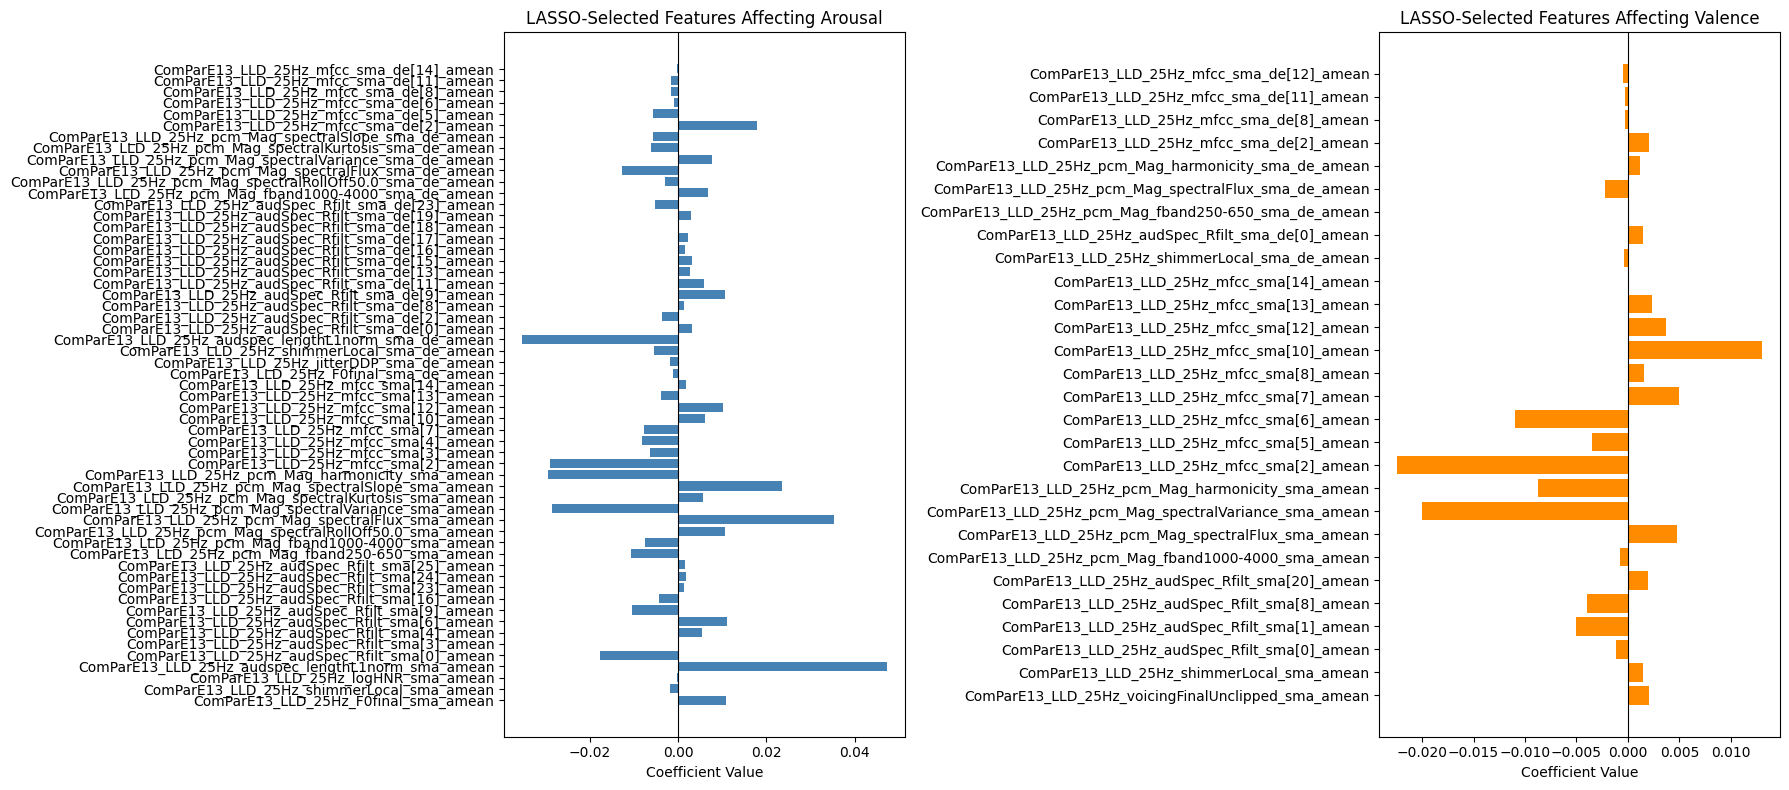

Number of Features used for Arousal: 57
Number of Features used for Valence: 28


In [41]:
import matplotlib.pyplot as plt
lasso_coef_arousal = lasso_cv_arousal.coef_
lasso_coef_valence = lasso_cv_valence.coef_
feature_names = x_train.columns
selected_features_arousal = np.array(feature_names)[lasso_coef_arousal != 0]
selected_coefs_arousal = lasso_coef_arousal[lasso_coef_arousal != 0]
selected_features_valence = np.array(feature_names)[lasso_coef_valence != 0]
selected_coefs_valence = lasso_coef_valence[lasso_coef_valence != 0]

fig, axes = plt.subplots(1, 2, figsize=(18, 8), sharey=False)
axes[0].barh(selected_features_arousal, selected_coefs_arousal, color='steelblue')
axes[0].axvline(0, color='black', linewidth=0.8)
axes[0].set_title("LASSO-Selected Features Affecting Arousal")
axes[0].set_xlabel("Coefficient Value")
axes[1].barh(selected_features_valence, selected_coefs_valence, color='darkorange')
axes[1].axvline(0, color='black', linewidth=0.8)
axes[1].set_title("LASSO-Selected Features Affecting Valence")
axes[1].set_xlabel("Coefficient Value")
plt.tight_layout()
plt.show()

print(f"Number of Features used for Arousal: {len(x_train_selected_arousal[0])}")
print(f"Number of Features used for Valence: {len(x_train_selected_valence[0])}")

1. Select and justify appropriate threshold values for binarizing both arousal and valence
annotations (the threshold for binarizing arousal should not necessarily be equal to the
threshold for binarizing valence). 

Our first step was to plot the distribution of the variables to see if anything may be discerned from them, we were curious if perhaps a multimodal distribution would appear. We also drew the lines of the mode, median and mean to discern the skew of the distributions.

From this we discerned that both plots were unimodal with a right skew, with valence giving a prominent right distribution and arousal giving a more subtle one. 

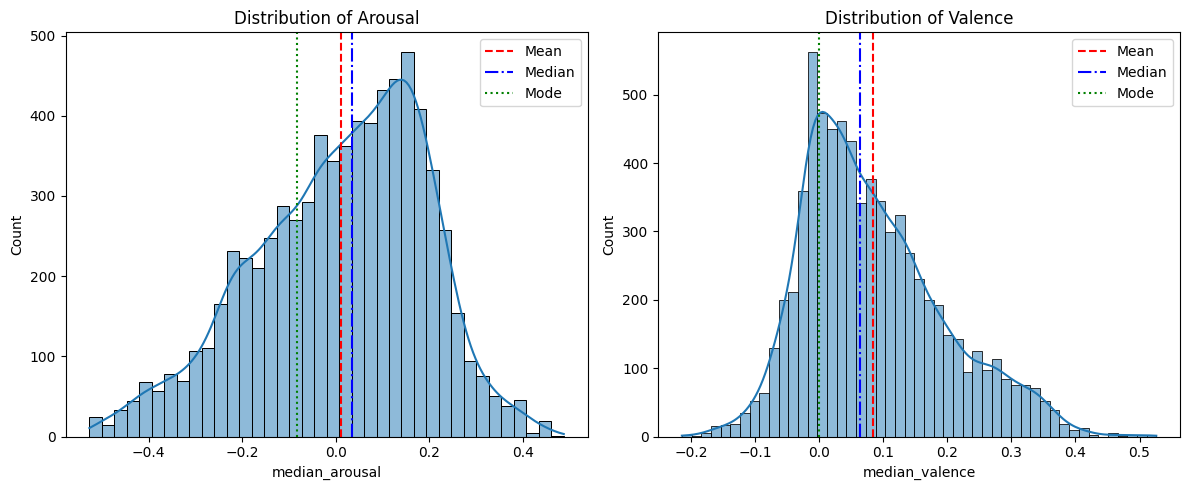

In [42]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
sns.histplot(y_arousal['median_arousal'], kde=True, ax=axes[0])
axes[0].axvline(y_arousal['median_arousal'].mean(), color='red', linestyle='--', label='Mean')
axes[0].axvline(y_arousal['median_arousal'].median(), color='blue', linestyle='-.', label='Median')
axes[0].axvline(y_arousal['median_arousal'].mode().iloc[0], color='green', linestyle=':', label='Mode')
axes[0].set_title("Distribution of Arousal")
axes[0].legend()
sns.histplot(y_valence['median_valence'], kde=True, ax=axes[1])
axes[1].axvline(y_valence['median_valence'].mean(), color='red', linestyle='--', label='Mean')
axes[1].axvline(y_valence['median_valence'].median(), color='blue', linestyle='-.', label='Median')
axes[1].axvline(y_valence['median_valence'].mode().iloc[0], color='green', linestyle=':', label='Mode')
axes[1].set_title("Distribution of Valence")
axes[1].legend()
plt.tight_layout()
plt.show()

We then went for a K-Means Clustering approach to find natural groupings, and given it clusteres on the mean of the target we obtained similar results to the previously established distributions.

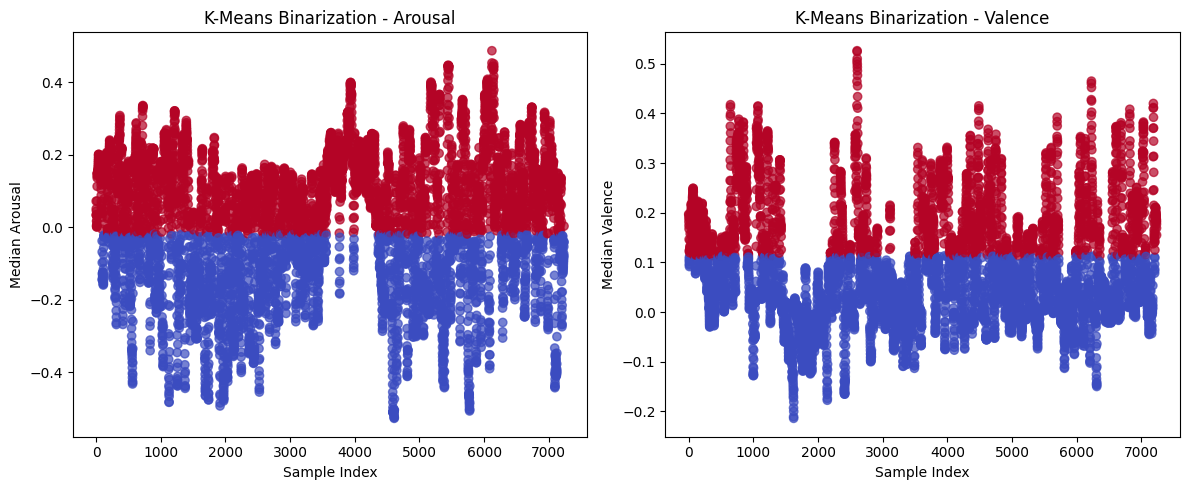

In [43]:
from sklearn.cluster import KMeans

arousal_values = y_arousal['median_arousal'].values.reshape(-1, 1)
valence_values = y_valence['median_valence'].values.reshape(-1, 1)
kmeans_arousal = KMeans(n_clusters=2, random_state=42).fit(arousal_values)
kmeans_valence = KMeans(n_clusters=2, random_state=42).fit(valence_values)

# Masked so 1 is the higher value
if kmeans_arousal.cluster_centers_[0] > kmeans_arousal.cluster_centers_[1]:
    kmeans_arousal.labels_ = 1 - kmeans_arousal.labels_
if kmeans_valence.cluster_centers_[0] > kmeans_valence.cluster_centers_[1]:
    kmeans_valence.labels_ = 1 - kmeans_valence.labels_

fig, axes = plt.subplots(1, 2, figsize=(12, 5))
axes[0].scatter(range(len(arousal_values)),y_arousal['median_arousal'], c=kmeans_arousal.labels_, cmap='coolwarm', alpha=0.7)
axes[0].set_title('K-Means Binarization - Arousal')
axes[0].set_xlabel('Sample Index')
axes[0].set_ylabel('Median Arousal')
axes[1].scatter(range(len(valence_values)),y_valence['median_valence'], c=kmeans_valence.labels_, cmap='coolwarm', alpha=0.7)
axes[1].set_title('K-Means Binarization - Valence')
axes[1].set_xlabel('Sample Index')
axes[1].set_ylabel('Median Valence')
plt.tight_layout()
plt.show()

We ultimately decided to set the theshold of binarization to the median of the distributions for perfectly balanced classes.

In [51]:
y_arousal_median_threshold = y_arousal['median_arousal'].median()
y_arousal_valence_threshold = y_valence['median_valence'].median()

binarized_arousal = (y_arousal['median_arousal'] >= y_arousal_median_threshold).astype(int)
binarized_valence = (y_valence['median_valence'] >= y_arousal_valence_threshold).astype(int)

print(binarized_arousal.values)
print(binarized_valence.values)

[1 1 1 ... 0 0 0]
[1 1 1 ... 1 1 1]


2. Implement a predictive model for each binarized response variable.

For this we decided on Support Vector Machines, given they were the most approriate linear classifier for high dimensional data

In [ ]:
from sklearn.svm import SVC

svm_arousal_binarized = SVC(kernel='rbf', random_state=42)
svm_arousal_binarized.fit(X_train_scaled, binarized_arousal.values)

svm_valence_binarized = SVC(kernel='rbf', random_state=42)
svm_valence_binarized.fit(X_train_scaled, binarized_valence.values)

y_pred = svm_arousal_binarized.predict(X_test_scaled)
y_pred = svm_valence_binarized.predict(X_test_scaled)

glm_predictions_valence = glm_results_valence.predict(x_test_glm_valence)
glm_predictions_arousal = glm_results_arousal.predict(x_test_glm_arousal)

 Task 3 
 In  this  task,  you  will  identify  similar  observations  captured  from  the  first  participant 
(participant ID = 1). Complete the following steps: 

1. Create  groups  of  similar  observations  from  the  first  participant  by  proposing  and 
implementing two suitable algorithms. 

We created a subset of the dataset by selecting only participant 1's data, we subsequently dropped the partipants column as this data is uneccassary. We also removed the median_arousal and median_variance as this section is based on creating groups of similar observations (features) and these last two columns are annotations/scores.

In [45]:
df = pd.read_csv("project_data.csv")

participant_df = df[df["Participant"] == 1]
participant_df = participant_df.drop(columns=["Participant",'median_arousal', 'median_valence'])
participant_df = scaler.fit_transform(participant_df)

df.to_csv('out.csv',index=False)


For this question I would like to perform Hierarchical clustering using complete linkage and K-mediods with random initialization to further minimize the optimization criterion along with forward step wise assignment.

[[-1.6655502  -1.01817751  0.16294618 ... -0.23418235 -1.20737625
  -0.68451033]
 [-1.54753145 -0.9881725   0.42224515 ... -0.5539344  -0.77802563
   0.41316153]
 [-0.97721556 -0.724075   -0.1463809  ...  0.48567338  0.35631349
  -0.50712434]
 ...
 [ 1.22994967  1.14133783  0.28616827 ...  2.01105046  0.85334015
  -0.7505782 ]
 [ 1.59712729  1.0084342   1.37267361 ...  3.36583261  4.2615225
   4.64867052]
 [ 2.17470656  1.19251172 -1.57868815 ...  3.29635978  6.5935185
   6.7735306 ]]


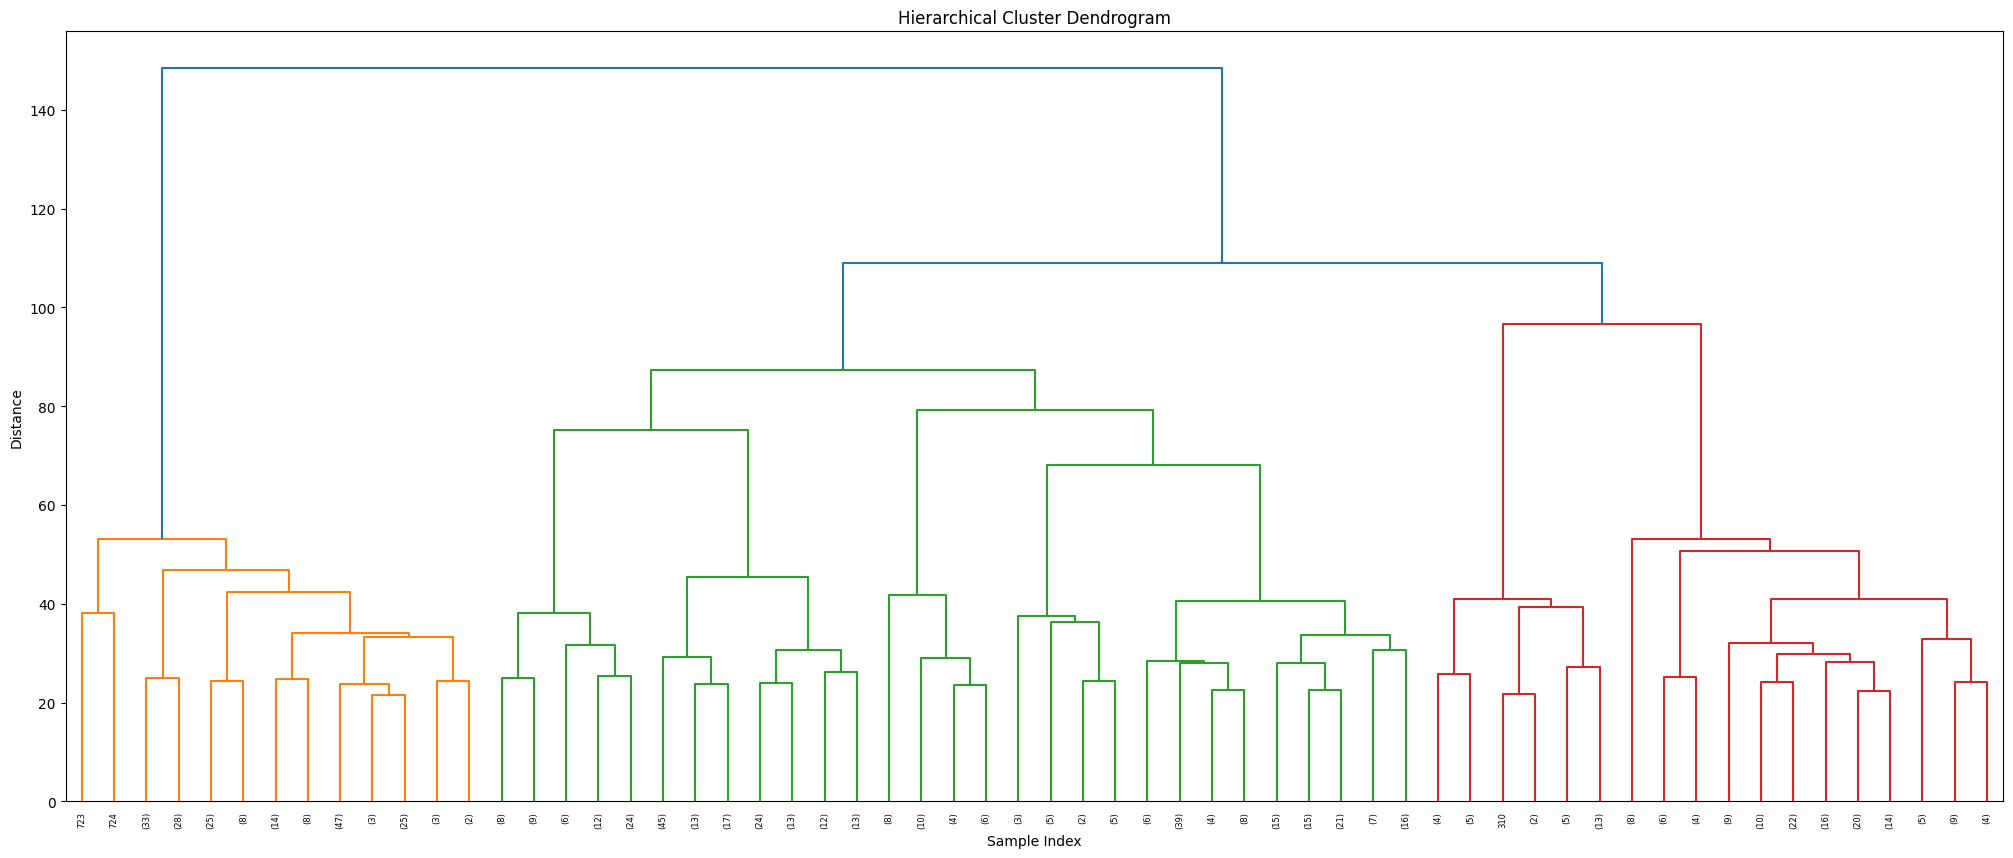

In [46]:
from scipy.cluster.hierarchy import dendrogram, linkage

print(participant_df)
plt.figure(figsize=(25,10))
dn = dendrogram(linkage(participant_df,'ward'),truncate_mode='lastp',p=60)
plt.title('Hierarchical Cluster Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
plt.show()

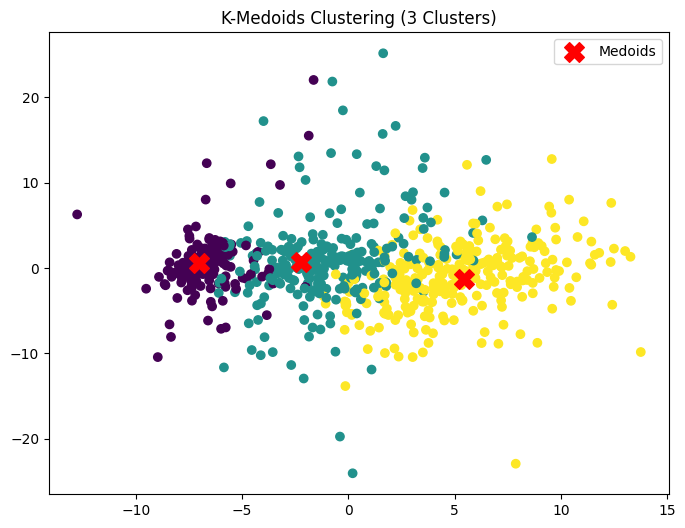

In [47]:

from sklearn_extra.cluster import KMedoids
from sklearn.decomposition import PCA

#kmedoids = KMedoids(n_clusters=2, random_state=0).fit(X)
kmedoids = KMedoids(n_clusters=3, random_state=42)
labels = kmedoids.fit_predict(participant_df)

# PCA for visualization
pca = PCA(n_components=2)
X_pca = pca.fit_transform(participant_df)

plt.figure(figsize=(8, 6))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=labels, cmap='viridis')
plt.scatter(X_pca[kmedoids.medoid_indices_, 0], X_pca[kmedoids.medoid_indices_, 1], c='red', marker='X', s=200, label='Medoids')
plt.title('K-Medoids Clustering (3 Clusters)')
plt.legend()
plt.show()